In [22]:
# 忽略warnings
import warnings 
warnings.filterwarnings('ignore') 

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import imdb
from keras import optimizers
from keras import metrics
from keras import models
from keras import losses
from keras import layers

# 03. 神经网络入门
本章涵盖神经网络最常见的三种使用场景：二分类问题、多分类问题和标量回归问题。
+ 将电影评论划分为正面或负面（二分类问题）
+ 将新闻按主题分类（多分类问题）
+ 根据房地产数据估算房屋价格（回归问题）

## 3.1 神经网络剖析
训练神经网络主要围绕以下四个方面。
+ 层，多个层组合成网络（或模型）
+ 输入数据和相应的目标
+ 损失函数，即用于学习的反馈信号
+ 优化器，决定学习过程如何进行

如`图3-1`所示：多个层链接在一起组成了网络，将输入数据映射为预测值。然后损失函数将这些预测值与目标进行比较，得到损失值，用于衡量网络预测值与预期结果的匹配程度。优化器使用这个损失值来更新网络的权重。

<img src="images/03_01.png" style="width:350px;"/>

### 3.1.1 层：深度学习的基础组件
神经网络的基本数据结构是`层`。`层`是一个数据处理模块，将一个或多个输入张量转换为一个或多个输出张量。有些层是无状态的，但大多数的层是有状态的，即层的`权重`。`权重`是利用随机梯度下降学到的一个或多个张量，其中包含网络的知识。

不同的张量格式与不同的数据处理类型需要用到不同的层。例如：
+ 简单的向量数据保存在形状为` (samples, features) `的`2D张量`中，通常用`密集连接层`［densely connected layer，也叫`全连接层`（fully connected layer）或`密集层`（dense layer），对应于`Keras`的`Dense`类］来处理
+ 序列数据保存在形状为` (samples, timesteps, features) `的`3D张量`中，通常用`循环层`（recurrent layer，比如`Keras`的`LSTM`层）来处理
+ 图像数据保存在`4D张量`中，通常用`二维卷积层`（`Keras`的`Conv2D`）来处理

你可以将层看作深度学习的乐高积木，`Keras`等框架则将这种比喻具体化。在`Keras`中，构建深度学习模型就是将相互兼容的多个层拼接在一起，以建立有用的数据变换流程。这里`层兼容性`（layer compatibility）具体指的是每一层只接受特定形状的输入张量，并返回特定形状的输出张量。

看看下面这个例子。

In [2]:
# 有32个输出单元的密集层
layer = layers.Dense(32, input_shape=(784,))
layer.get_config()

{'name': 'dense_1',
 'trainable': True,
 'batch_input_shape': (None, 784),
 'dtype': 'float32',
 'units': 32,
 'activation': 'linear',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'scale': 1.0,
   'mode': 'fan_avg',
   'distribution': 'uniform',
   'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

我们创建了一个层，只接受第一个维度大小为784的2D张量（第0轴是批量维度，其大小没有指定，因此可以任意取值）作为输入。这个层将返回一个张量，第一个维度的大小变成了32。因此，这个层后面只能连接一个接受32维向量作为输入的层。

使用`Keras`时，你无须担心兼容性，因为向模型中添加的层都会自动匹配输入层的形状。

In [3]:
model = models.Sequential()
model.add(layers.Dense(32, input_shape=(784,)))
model.add(layers.Dense(32))

其中第二层没有输入形状（input_shape）的参数，相反，它可以自动推导出输入形状等于上一层的输出形状。

### 3.1.2 模型：层构成的网络
深度学习模型是层构成的有向无环图。最常见的例子就是层的线性堆叠，将单一输入映射为单一输出。

但随着深入学习，你会接触到更多类型的网络拓扑结构。一些常见的网络拓扑结构如下：
+ 双分支（two-branch）网络
+ 多头（multihead）网络
+ Inception 模块

网络的拓扑结构定义了一个`假设空间`（hypothesis space）。选定了网络拓扑结构，意味着将`假设空间`限定为一系列特定的张量运算，将输入数据映射为输出数据。然后，你需要为这些张量运算的权重张量找到一组合适的值。

> 机器学习可以定义为：在预先定义好的假设空间中，利用反馈信号的指引来寻找输入数据的有用表示

选择正确的网络架构更像是一门艺术而不是科学。虽然有一些最佳实践和原则，但只有动手实践才能让你成为合格的神经网络架构师。

### 3.1.3 损失函数与优化器：配置学习过程的关键
一旦确定了网络架构，你还需要选择以下两个参数：
+ 损失函数（目标函数）——在训练过程中需要将其最小化。它能够衡量当前任务是否已成功完成
+ 优化器——决定如何基于损失函数对网络进行更新。它执行的是随机梯度下降（SGD）的某个变体

具有多个输出的神经网络可能具有多个损失函数（每个输出对应一个损失函数）。但是，梯度下降过程必须基于单个标量损失值。因此，对于具有多个损失函数的网络，需要将所有损失函数取平均，变为一个标量值。

选择正确的目标函数对解决问题是非常重要的。网络的目的是使损失尽可能最小化，因此，如果目标函数与成功完成当前任务不完全相关，那么网络最终得到的结果可能会不符合你的预期。

你可以遵循一些简单的指导原则来选择正确的损失函数：
+ 对于二分类问题，你可以使用`二元交叉熵`（binary crossentropy）损失函数
+ 对于多分类问题，可以用`分类交叉熵`（categorical crossentropy）损失函数
+ 对于回归问题，可以用`均方误差`（mean-squared error）损失函数
+ 对于序列学习问题，可以用`联结主义时序分类`（CTC，connectionist temporal classification）损失函数，等等

只有在面对真正全新的研究问题时，你才需要自主开发目标函数。

## 3.2 Keras简介
`Keras`是一个Python深度学习框架，可以方便地定义和训练几乎所有类型的深度学习模型。

`Keras`具有以下重要特性：
+ 相同的代码可以在CPU或GPU上无缝切换运行
+ 具有用户友好的API，便于快速开发深度学习模型的原型
+ 内置支持卷积网络（用于计算机视觉）、循环网络（用于序列处理）以及二者的任意组合
+ 支持任意网络架构：多输入或多输出模型、层共享、模型共享等。这也就是说，Keras能够构建任意深度学习模型，无论是生成式对抗网络还是神经图灵机

`Keras`是机器学习竞赛网站`Kaggle`上的热门框架，最新的深度学习竞赛中，几乎所有的优胜者用的都是`Keras`模型，如`图3-2`所示。

<img src="images/03_02.png" style="width:500px;"/>

### 3.2.1 Keras/TensorFlow/Theano和CNTK
`Keras`是一个模型级（model-level）的库，为开发深度学习模型提供了高层次的构建模块。它不处理张量操作、求微分等低层次的运算。相反，它依赖于一个专门的、高度优化的张量库来完成这些运算，这个张量库就是`Keras`的`后端引擎`（backend engine）。`Keras`没有选择单个张量库并将`Keras`实现与这个库绑定，而是以模块化的方式处理这个问题，几个不同的后端引擎都可以无缝嵌入到`Keras`中。

<img src="images/03_03.png" style="width:300px;"/>

`TensorFlow`、`CNTK`和`Theano`是当今深度学习的几个主要平台。你用`Keras`写的每一段代码都可以在这三个后端上运行，无须任何修改。

`Keras`可以在CPU和GPU上无缝运行。在CPU上运行时，`TensorFlow`本身封装了一个低层次的张量运算库，叫作`Eigen`；在GPU上运行时，`TensorFlow`封装了一个高度优化的深度学习运算库，叫作NVIDIA CUDA深度神经网络库（cuDNN）。

### 3.2.2 使用Keras开发：概述
典型的`Keras`工作流程：
1. 定义训练数据：输入张量和目标张量
2. 定义层组成的网络（或模型），将输入映射到目标
3. 配置学习过程：选择损失函数、优化器和需要监控的指标
4. 调用模型的fit方法在训练数据上进行迭代

定义模型有两种方法：
1. 使用`Sequential`类（仅用于层的线性堆叠，这是目前最常见的网络架构）
2. 使用函数式API（functional API，用于层组成的有向无环图，让你可以构建任意形式的架构）

例如，利用`Sequential`类定义的两层模型：

In [4]:
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(784,)))
model.add(layers.Dense(10, activation='softmax'))

下面是用函数式API定义的相同模型。

In [5]:
input_tensor = layers.Input(shape=(784,))
x = layers.Dense(32, activation='relu')(input_tensor)
output_tensor = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs=input_tensor, outputs=output_tensor)

利用函数式API，你可以操纵模型处理的数据张量，并将层应用于这个张量，就好像这些层是函数一样。

> **注意**
> 第7章有关于函数式 API 的详细指南。在那之前，我们的代码示例中只会用到Sequential类。

一旦定义好了模型架构，使用`Sequential`模型还是函数式API就不重要了。接下来的步骤都是相同的。

In [6]:
model.compile(
    optimizer=optimizers.RMSprop(lr=0.001),
    loss='mse',
    metrics=['accuracy'])

最后，学习过程就是通过`fit()`方法将输入数据的Numpy数组（和对应的目标数据）传入模型，这一做法与`Scikit-Learn`及其他机器学习库类似。

```python
model.fit(input_tensor, target_tensor, batch_size=128, epochs=10)
```

## 3.3 建立深度学习工作站
[略]


## 3.4 电影评论分类：二分类问题
二分类问题可能是应用最广泛的机器学习问题。在这个例子中，你将学习根据电影评论的文字内容将其划分为正面或负面。

### 3.4.1 IMDB 数据集
本节使用IMDB的50000条严重两极分化的评论。数据集被分为用于训练的25000条评论与用于测试的25000条评论，训练集和测试集都包含50%的正面评论和50%的负面评论。

IMDB数据集也内置于`Keras`库，它已经过预处理：评论(单词序列)已经被转换为整数序列，其中每个整数代表字典中的某个单词。

In [7]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

参数`num_words=10000`的意思是仅保留训练数据中前10000个最常出现的单词。低频单词将被舍弃。这样得到的向量数据不会太大，便于处理。

`train_data`和`test_data`这两个变量都是评论组成的列表，每条评论又是单词索引组成的列表。`train_labels`和`test_labels`都是0(负面)和1(正面)组成的列表。

In [8]:
print(train_data[0], train_labels[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32] 1


由于限定为前10000个最常见的单词，单词索引都不会超过10000。

In [9]:
max([max(sequence) for sequence in train_data])

9999

下面这段代码很有意思，你可以将某条评论迅速解码为英文单词。

In [10]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

### 3.4.2 准备数据
你不能将整数序列直接输入神经网络。你需要将列表转换为张量。转换方法有以下两种：
+ 填充列表，使其具有相同的长度，再将列表转换成形状为`(samples, word_indices)`的整数张量，然后网络第一层使用能处理这种整数张量的层（即`Embedding`层）
+ 对列表进行one-hot编码，将其转换为0和1组成的向量。然后网络第一层可以用`Dense`层，它能够处理浮点数向量数据

下面我们采用后一种方法将数据向量化。为了加深理解，你可以手动实现这一方法，如下所示。

In [11]:
def vectorize_sequences(sequences, dimension=10000):
    # 创建一个形状为(len(sequences), dimension)的零矩阵
    results = np.zeros((len(sequences), dimension))   
    for i, sequence in enumerate(sequences):
        # 将results[i]的指定索引设为1
        results[i, sequence] = 1. 
    return results

x_train = vectorize_sequences(train_data)  
x_test = vectorize_sequences(test_data)

x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

你还应该将标签向量化，这很简单。

In [12]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

现在可以将数据输入到神经网络中。

### 3.4.3 构建网络
输入数据是向量，而标签是标量（1和0），这是你会遇到的最简单的情况。有一类网络在这种问题上表现很好，就是带有`relu`激活的全连接层（`Dense`）的简单堆叠，比如`Dense(16, activation='relu')`。

传入`Dense`层的参数（16）是该层隐藏单元的个数。一个`隐藏单元`（hidden unit）是该层表示空间的一个维度。每个带有`relu`激活的`Dense`层都实现了下列张量运算：

```python
output = relu(dot(W, input) + b)
```

16个隐藏单元对应的权重矩阵`W`的形状为`(input_dimension, 16)`，与`W`做点积相当于将输入数据投影到16维表示空间中（然后再加上偏置向量`b`并应用`relu`运算）。你可以将表示空间的维度直观地理解为“网络学习内部表示时所拥有的自由度”。隐藏单元越多（即更高维的表示空间），网络越能够学到更加复杂的表示，但网络的计算代价也变得更大，而且可能会导致学到不好的模式（这种模式会提高训练数据上的性能，但不会提高测试数据上的性能）。

对于这种`Dense`层的堆叠，你需要确定以下两个关键架构：
+ 网络有多少层
+ 每层有多少个隐藏单元。

第4章中的原则将会指导你对上述问题做出选择。现在你只需要相信我选择的下列架构：
+ 两个中间层，每层都有16个隐藏单元
+ 第三层输出一个标量，预测当前评论的情感
+ 中间层使用`relu`作为激活函数，最后一层使用`sigmoid`激活以输出一个`0~1`范围内的概率值（表示样本的目标值等于1的可能性，即评论为正面的可能性）

`relu`（rectified linear unit，整流线性单元）函数将所有负值归零（见`图3-4`），而`sigmoid`函数则将任意值“压缩”到 [0, 1] 区间内（见`图3-5`），其输出值可以看作概率值。

<img src="images/03_04_05.png" style="width:600px;"/>

`图3-6`显示了网络的结构。

<img src="images/03_06.png" style="width:250px;"/>

In [13]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

> **什么是激活函数？为什么要使用激活函数？**
> 
> 如果没有`relu`等激活函数（也叫非线性），`Dense`层将只包含两个线性运算——点积和加法：
> ```python
> output = dot(W, input) + b
> ```
>这样`Dense`层就只能学习输入数据的线性变换（仿射变换）：该层的假设空间是从输入数据到16位空间所有可能的线性变换集合。这种假设空间非常有限，无法利用多个表示层的优势，因为多个线性层堆叠实现的仍是线性运算，添加层数并不会扩展假设空间。
> 
> 为了得到更丰富的假设空间，从而充分利用多层表示的优势，你需要添加非线性或激活函数。`relu`是深度学习中最常用的激活函数，但还有许多其他函数可选，它们都有类似的奇怪名称，比如`prelu`、`elu`等。

最后，你需要选择损失函数和优化器。由于你面对的是一个二分类问题，网络输出是一个概率值（网络最后一层使用`sigmoid`激活函数，仅包含一个单元），那么最好使用`binary_crossentropy`（二元交叉熵）损失。这并不是唯一可行的选择，比如你还可以使用`mean_squared_error`（均方误差）。但对于输出概率值的模型，`交叉熵`（crossentropy）往往是最好的选择。交叉熵是来自于信息论领域的概念，用于衡量概率分布之间的距离，在这个例子中就是真实分布与预测值之间的距离。

下面的步骤是用`rmsprop`优化器和`binary_crossentropy`损失函数来配置模型。注意，我们还在训练过程中监控精度。

In [14]:
model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


有时你可能希望配置自定义优化器的参数，或者传入自定义的损失函数或指标函数。前者可通过向`optimizer`参数传入一个优化器类实例来实现，后者可通过向`loss`和`metrics`参数传入函数对象来实现。

In [15]:
model.compile(
    optimizer=optimizers.RMSprop(lr=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [18]:
model.compile(
    optimizer=optimizers.RMSprop(lr=0.001),
    loss=losses.binary_crossentropy,
    metrics=[metrics.binary_accuracy])

### 3.4.4 验证你的方法
为了在训练过程中监控模型在前所未见的数据上的精度，你需要将原始训练数据留出10000个样本作为验证集。

In [19]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

现在使用512个样本组成的小批量，将模型训练20个轮次（即对`partial_x_train`和`partial_y_train`两个张量中的所有样本进行20次迭代）。与此同时，你还要监控在留出的10000个样本上的损失和精度。你可以通过将验证数据传入`validation_data`参数来完成。

In [20]:
model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc'])

history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))


Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 180us/step - loss: 0.5192 - acc: 0.7803 - val_loss: 0.3807 - val_acc: 0.8722
Epoch 2/20
15000/15000 [==============================] - 2s 121us/step - loss: 0.3042 - acc: 0.9045 - val_loss: 0.3075 - val_acc: 0.8830
Epoch 3/20
15000/15000 [==============================] - 2s 115us/step - loss: 0.2212 - acc: 0.9308 - val_loss: 0.2802 - val_acc: 0.8892
Epoch 4/20
15000/15000 [==============================] - 2s 117us/step - loss: 0.1731 - acc: 0.9432 - val_loss: 0.2747 - val_acc: 0.8886
Epoch 5/20
15000/15000 [==============================] - 2s 118us/step - loss: 0.1404 - acc: 0.9563 - val_loss: 0.2801 - val_acc: 0.8872
Epoch 6/20
15000/15000 [==============================] - 2s 118us/step - loss: 0.1142 - acc: 0.9647 - val_loss: 0.3135 - val_acc: 0.8834
Epoch 7/20
15000/15000 [==============================] - 2s 119us/step - loss: 0.0926 - acc: 0.9740 - val_loss: 0.3131 -

在CPU上运行，每轮的时间不到2秒，训练过程将在20秒内结束。每轮结束时会有短暂的停顿，因为模型要计算在验证集的10000个样本上的损失和精度。

> **注意**，调用`model.fit()`返回了一个`History`对象。这个对象有一个成员`history`，它是一个字典，包含训练过程中的所有数据



In [21]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

字典中包含4个条目，对应训练过程和验证过程中监控的指标。

绘制训练损失和验证损失：

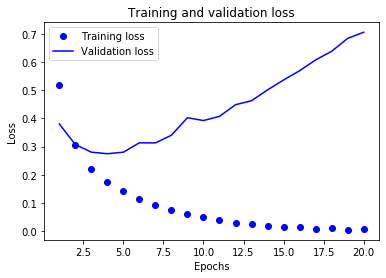

In [23]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

# 'bo'表示蓝色圆点
plt.plot(epochs, loss_values, 'bo', label='Training loss') 
# 'b'表示蓝色实线
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

绘制训练精度和验证精度：

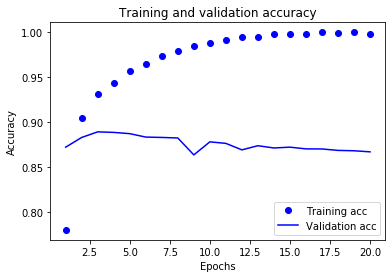

In [24]:
# 清空图像
plt.clf() 
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

如你所见，训练损失每轮都在降低，训练精度每轮都在提升。这就是梯度下降优化的预期结果。但验证损失和验证精度并非如此：它们似乎在第四轮达到最佳值：模型在训练数据上的表现越来越好，但在前所未见的数据上不一定表现得越来越好。这就是`过拟合`（overfit）。

为了防止过拟合，你可以在3轮之后停止训练。通常来说，你可以使用许多方法来降低过拟合，我们将在第4章中详细介绍。

我们从头开始训练一个新的网络，训练4轮，然后在测试数据上评估模型。

In [25]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
25000/25000 [==============================] - 2s 81us/step - loss: 0.4483 - accuracy: 0.8253
Epoch 2/4
25000/25000 [==============================] - 2s 76us/step - loss: 0.2582 - accuracy: 0.9088
Epoch 3/4
25000/25000 [==============================] - 2s 72us/step - loss: 0.1983 - accuracy: 0.9295
Epoch 4/4
25000/25000 [==============================] - 1s 55us/step


In [26]:
results

[0.2952362303590775, 0.8840399980545044]

这种相当简单的方法得到了`88%`的精度。利用最先进的方法，你应该能够得到接近`95%`的精度。

### 3.4.6 进一步的实验
通过以下实验，你可以确信前面选择的网络架构是非常合理的，虽然仍有改进的空间：
+ 前面使用了两个隐藏层。你可以尝试使用一个或三个隐藏层，然后观察对验证精度和测试精度的影响
+ 尝试使用更多或更少的隐藏单元，比如32个、64个等
+ 尝试使用`mse`损失函数代替`binary_crossentropy`
尝试使用`tanh`激活代替`relu`

### 3.4.7 小结
下面是你应该从这个例子中学到的要点：
+ 通常需要对原始数据进行大量预处理，以便将其转换为张量输入到神经网络中。单词序列可以编码为二进制向量，但也有其他编码方式
+ 带有`relu`激活的`Dense`层堆叠，可以解决很多种问题（包括情感分类），你可能会经常用到这种模型
+ 对于二分类问题（两个输出类别），网络的最后一层应该是只有一个单元并使用`sigmoid`激活的`Dense`层，网络输出应该是`0~1`范围内的标量，表示概率值
+ 对于二分类问题的`sigmoid`标量输出，你应该使用`binary_crossentropy`损失函数
+ 无论你的问题是什么，`rmsprop`优化器通常都是足够好的选择。这一点你无须担心
+ 随着神经网络在训练数据上的表现越来越好，模型最终会过拟合，并在前所未见的数据上得到越来越差的结果。一定要一直监控模型在训练集之外的数据上的性能

## 3.5 新闻分类：多分类问题
本节你会构建一个网络，将路透社新闻划分为46个互斥的主题。因为有多个类别，所以这是`多分类`（multiclass classification）问题。因为每个数据点只能划分到一个类别，所以更具体地说，这是`单标签、多分类`（single-label, multiclass classification）问题的一个例子。如果每个数据点可以划分到多个类别（主题），那它就是一个`多标签、多分类`（multilabel, multiclass classification）问题。

### 3.5.1 路透社数据集
路透社数据集是一个简单的、广泛使用的文本分类数据集。它包括46个不同的主题：某些主题的样本更多，但训练集中每个主题都有至少10个样本。路透社数据集也内置为`Keras`的一部分。